/tmp/ipykernel_34769/2938183051.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lossPerRecord = float((y - mulV)**2/2)


Epoch: 1, Loss: 132219.50990086797, Validation Loss: 66107.73179592531
Epoch: 2, Loss: 85800.72307067864, Validation Loss: 42898.72415489228
Epoch: 3, Loss: 49381.93624027209, Validation Loss: 24689.716513750416
Epoch: 4, Loss: 22963.14709973055, Validation Loss: 11480.70771518648
Epoch: 5, Loss: 6528.960175424226, Validation Loss: 3263.9837277981487
Epoch: 6, Loss: 72.4684556125437, Validation Loss: 36.14157668919891
Epoch: 7, Loss: 35.75957647162403, Validation Loss: 17.81418315325519
Epoch: 8, Loss: 35.248022415711915, Validation Loss: 17.553412965684146
Epoch: 9, Loss: 35.189951089755525, Validation Loss: 17.526128509905227
Epoch: 10, Loss: 34.8782240776729, Validation Loss: 17.37369105539326
Epoch: 11, Loss: 34.75392465353672, Validation Loss: 17.308122639164885
Epoch: 12, Loss: 34.74924505483764, Validation Loss: 17.30713743847738
Epoch: 13, Loss: 35.020185873542275, Validation Loss: 17.44300288125209
Epoch: 14, Loss: 34.937650734180075, Validation Loss: 17.405573617705855
Epoch:

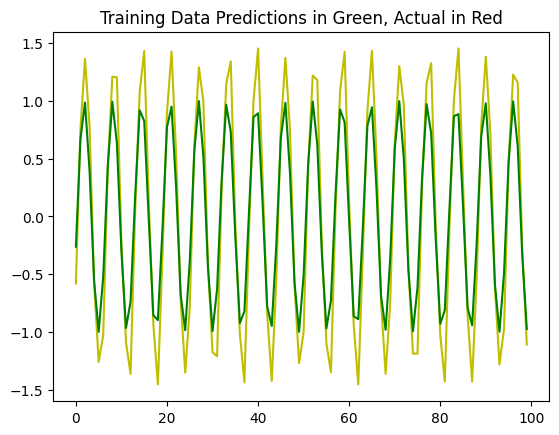

In [1]:
import math
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

class RNN:
    def __init__(self):
        # Установка параметров для архитектуры RNN
        self.learningRate = 0.0001
        self.seqLen = 50
        self.maxEpochs = 25
        self.hiddenDim = 100
        self.outputDim = 1
        self.bpttTruncate = 5  # Продолжительность обратного распространения через время
        self.minClipVal = -10
        self.maxClipVal = 10

    # Функция активации (сигмоид)
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    # Расчет потерь
    def calculateLoss(self, X, Y, U, V, W):
        loss = 0.0
        for i in range(Y.shape[0]):
            x, y = X[i], Y[i]
            prevActivation = np.zeros((self.hiddenDim, 1)) # значение предыдущей активации
            for timestep in range(self.seqLen):
                newInput = np.zeros(x.shape) # прямой проход, выполняется для каждого шага в последовательности
                newInput[timestep] = x[timestep] # определить один вход для этого временного шага
                mulU = np.dot(U, newInput)
                mulW = np.dot(W, prevActivation)
                sum = mulU + mulW
                activation = self.sigmoid(sum)
                mulV = np.dot(V, activation)
                prevActivation = activation
            # рассчитать и добавить потери за запись
            lossPerRecord = float((y - mulV)**2/2)
            loss += lossPerRecord
        # рассчитать потери после первого прохода Y
        return loss, activation

    # Расчет слоев
    def calcLayers(self, x, U, V, W, prevActivation):
        layers = []
        for timestep in range(self.seqLen):
            newInput = np.zeros(x.shape)
            newInput[timestep] = x[timestep]
            mulU = np.dot(U, newInput)
            mulW = np.dot(W, prevActivation)
            sum = mulW + mulU
            activation = self.sigmoid(sum)
            mulV = np.dot(V, activation)
            layers.append({'activation': activation, 'prevActivation': prevActivation})
            prevActivation = activation

        return layers, mulU, mulW, mulV

    # Обратное распространение ошибки
    def backprop(self, x, U, V, W, dmulV, mulU, mulW, layers):
        dU = np.zeros(U.shape)
        dV = np.zeros(V.shape)
        dW = np.zeros(W.shape)

        dU_t = np.zeros(U.shape)
        dV_t = np.zeros(V.shape)
        dW_t = np.zeros(W.shape)

        dU_i = np.zeros(U.shape)
        dW_i = np.zeros(W.shape)

        sum = mulU + mulW
        dsv = np.dot(np.transpose(V), dmulV)

        def getPreviousActivationDifferential(sum, ds, W):
            d_sum = sum * (1 - sum) * ds
            dmulW = d_sum * np.ones_like(ds)
            return np.dot(np.transpose(W), dmulW)

        for timestep in range(self.seqLen):
            dV_t = np.dot(dmulV, np.transpose(layers[timestep]['activation']))
            ds = dsv
            dprevActivation = getPreviousActivationDifferential(sum, ds, W)

            for _ in range(timestep-1, max(-1, timestep-self.bpttTruncate-1), -1):
                ds = dsv + dprevActivation
                dprevActivation = getPreviousActivationDifferential(sum, ds, W)
                dW_i = np.dot(W, layers[timestep]['prevActivation'])

                newInput = np.zeros(x.shape)
                newInput[timestep] = x[timestep]
                dU_i = np.dot(U, newInput)

                dU_t += dU_i
                dW_t += dW_i

            dU += dU_t
            dV += dV_t
            dW += dW_t

            # учесть возможные взрывающиеся градиенты
            if dU.max() > self.maxClipVal:
                dU[dU > self.maxClipVal] = self.maxClipVal
            if dV.max() > self.maxClipVal:
                dV[dV > self.maxClipVal] = self.maxClipVal
            if dW.max() > self.maxClipVal:
                dW[dW > self.maxClipVal] = self.maxClipVal

            if dU.min() < self.minClipVal:
                dU[dU < self.minClipVal] = self.minClipVal
            if dV.min() < self.minClipVal:
                dV[dV < self.minClipVal] = self.minClipVal
            if dW.min() < self.minClipVal:
                dW[dW < self.minClipVal] = self.minClipVal

        return dU, dV, dW

    # Обучение
    def train(self, U, V, W, X, Y, X_validation, Y_validation):
        for epoch in range(self.maxEpochs):
            # рассчитать начальные потери, т.е. что является выходом, учитывая случайный набор весов
            loss, prevActivation = self.calculateLoss(X, Y, U, V, W)

            # проверить потери при проверке
            valLoss, _ = self.calculateLoss(X_validation, Y_validation, U, V, W)

            print(f'Epoch: {epoch+1}, Loss: {loss}, Validation Loss: {valLoss}')

            # обучить модель/прямой проход
            for i in range(Y.shape[0]):
                x, y = X[i], Y[i]
                layers = []
                prevActivation = np.zeros((self.hiddenDim, 1))

                layers, mulU, mulW, mulV = self.calcLayers(x, U, V, W, prevActivation)

                # разница прогноза
                dmulV = mulV - y
                dU, dV, dW = self.backprop(x, U, V, W, dmulV, mulU, mulW, layers)

                # обновить веса
                U -= self.learningRate * dU
                V -= self.learningRate * dV
                W -= self.learningRate * dW
        return U, V, W

    # Предсказания на обучающем наборе
    def predict(self, U, V, W, X, Y):
        predictions = []
        for i in range(Y.shape[0]):
            x, y = X[i], Y[i]
            prevActivation = np.zeros((self.hiddenDim,1))
            # прямой проход
            for timestep in range(self.seqLen):
                mulU = np.dot(U, x)
                mulW = np.dot(W, prevActivation)
                sum = mulU + mulW
                activation = self.sigmoid(sum)
                mulV = np.dot(V, activation)
                prevActivation = activation
            predictions.append(mulV)

        predictions = np.array(predictions)

        plt.plot(predictions[:, 0,0], 'y')
        plt.plot(Y[:, 0], 'g')
        plt.title("Training Data Predictions in Green, Actual in Red")
        plt.show()

# Создание и обучение RNN
rnn = RNN()
sinWave = np.array([math.sin(x) for x in range(200)])
X = []
Y = []
numRecords = len(sinWave) - rnn.seqLen

for i in range(numRecords-50):
    X.append(sinWave[i:i+rnn.seqLen])
    Y.append(sinWave[i+rnn.seqLen])

X = np.expand_dims(np.array(X), axis=2)
Y = np.expand_dims(np.array(Y), axis=1)

X_validation = []
Y_validation = []
for i in range(numRecords-rnn.seqLen, numRecords):
    X_validation.append(sinWave[i:i+rnn.seqLen])
    Y_validation.append(sinWave[i+rnn.seqLen])

X_validation = np.expand_dims(np.array(X_validation), axis=2)
Y_validation = np.expand_dims(np.array(Y_validation), axis=1)

np.random.seed(12161)
U = np.random.uniform(0, 1, (rnn.hiddenDim, rnn.seqLen))
V = np.random.uniform(0, 1, (rnn.outputDim, rnn.hiddenDim))
W = np.random.uniform(0, 1, (rnn.hiddenDim, rnn.hiddenDim))

U, V, W = rnn.train(U, V, W, X, Y, X_validation, Y_validation)
rnn.predict(U, V, W, X, Y)